In [ ]:
def square(x:int)->int:
    return x**2

square(8)

64

In [ ]:
from typing import Union

def square(x:Union[int, float])->float:
    """
    
    """
    return x**2

square(8.4)



70.56

In [11]:
from typing import Optional

def nice_msg(name: Optional[str]) -> None:
    if name is None:
        print("Hi!")

    else:
        print(f"Hi there, {name}!")


nice_msg(None)


Hi!


In [13]:
from typing import Any

def print_value(x: Any):
    print(x)

print_value('hh')

hh


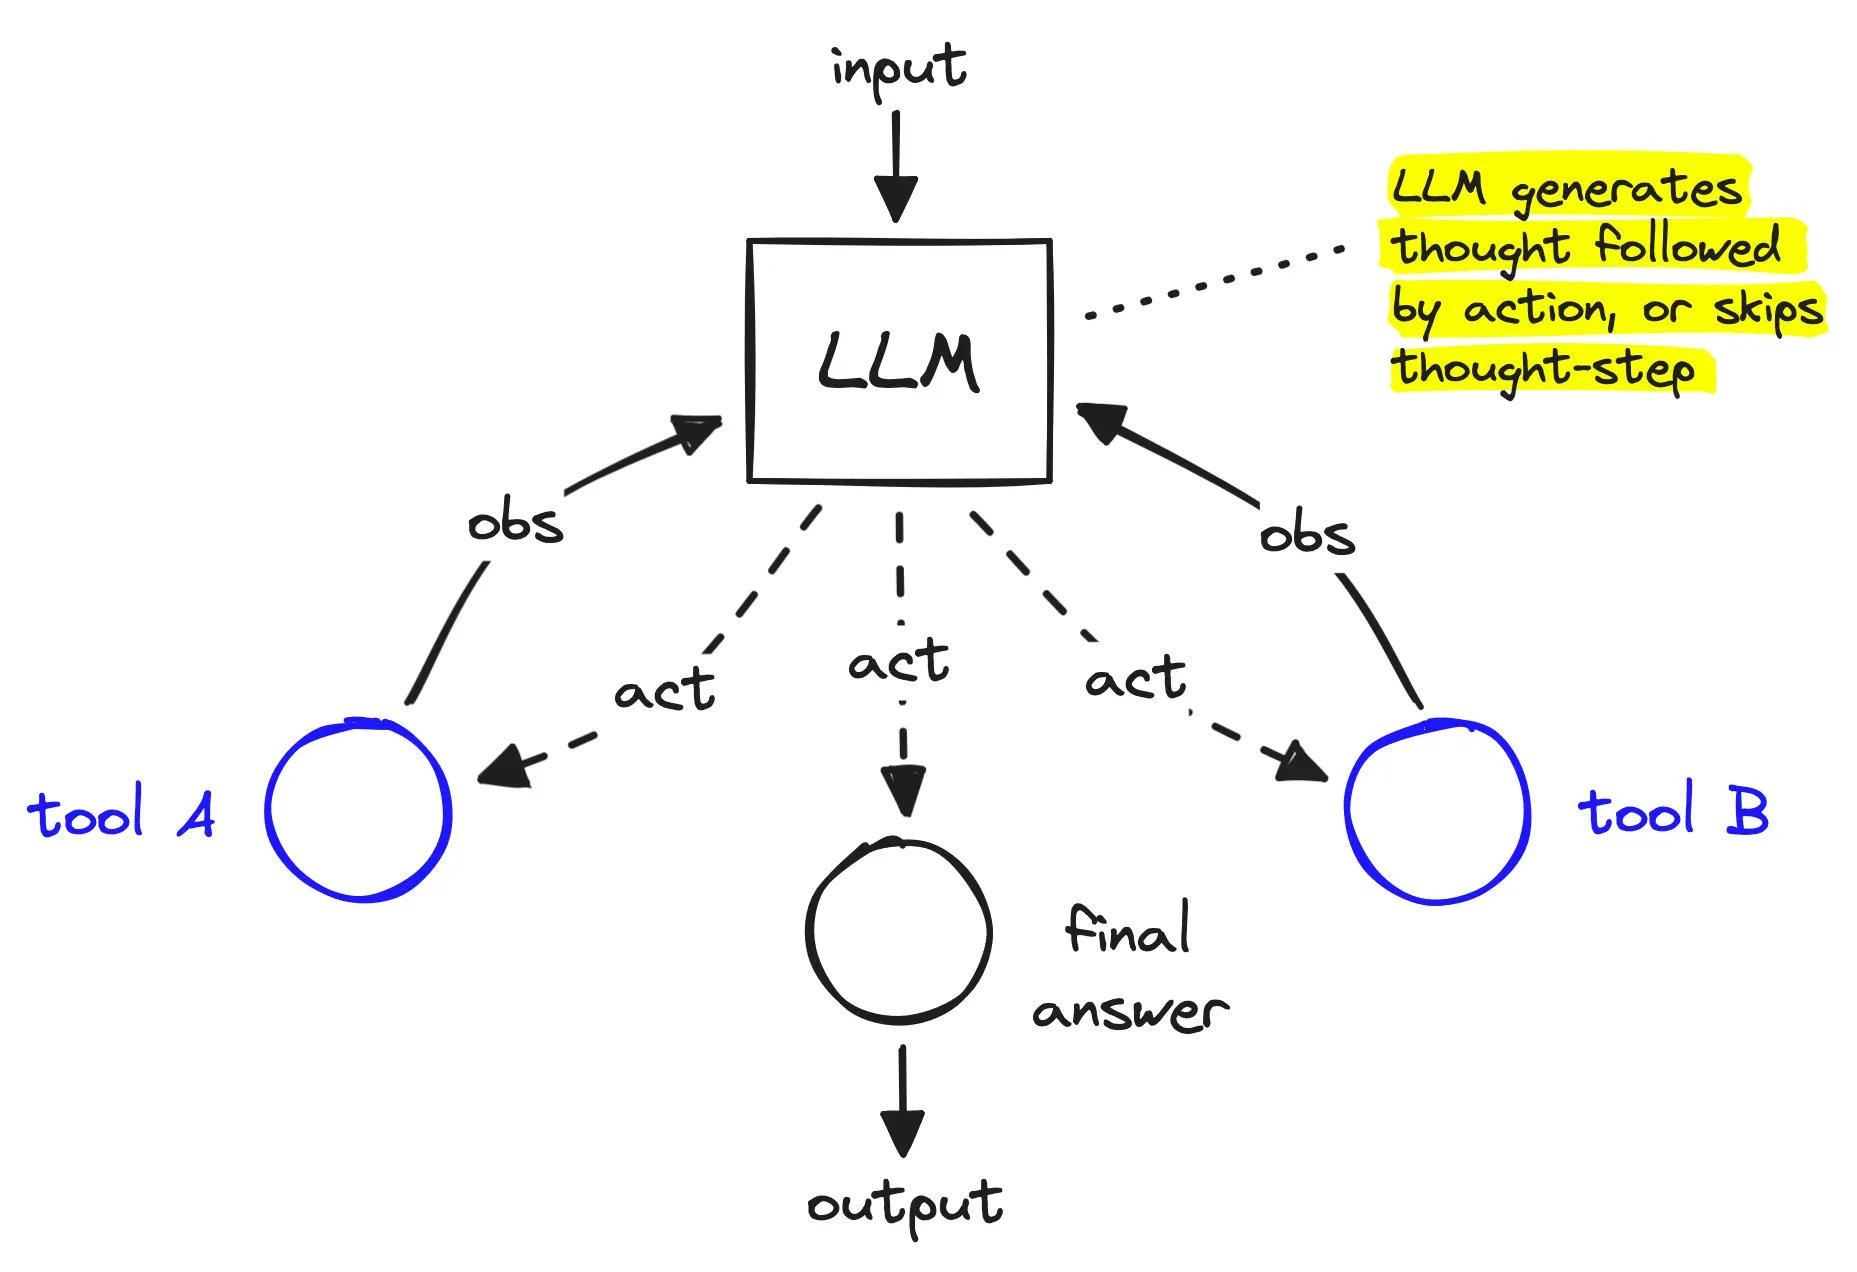

## Understanding State Machines in LangGraph

LangGraph adopts a state machine (graph-based) approach to orchestrate LLM workflows. This architecture models applications as collections of:
- Nodes
- Edges
- Shared State


### Key Components

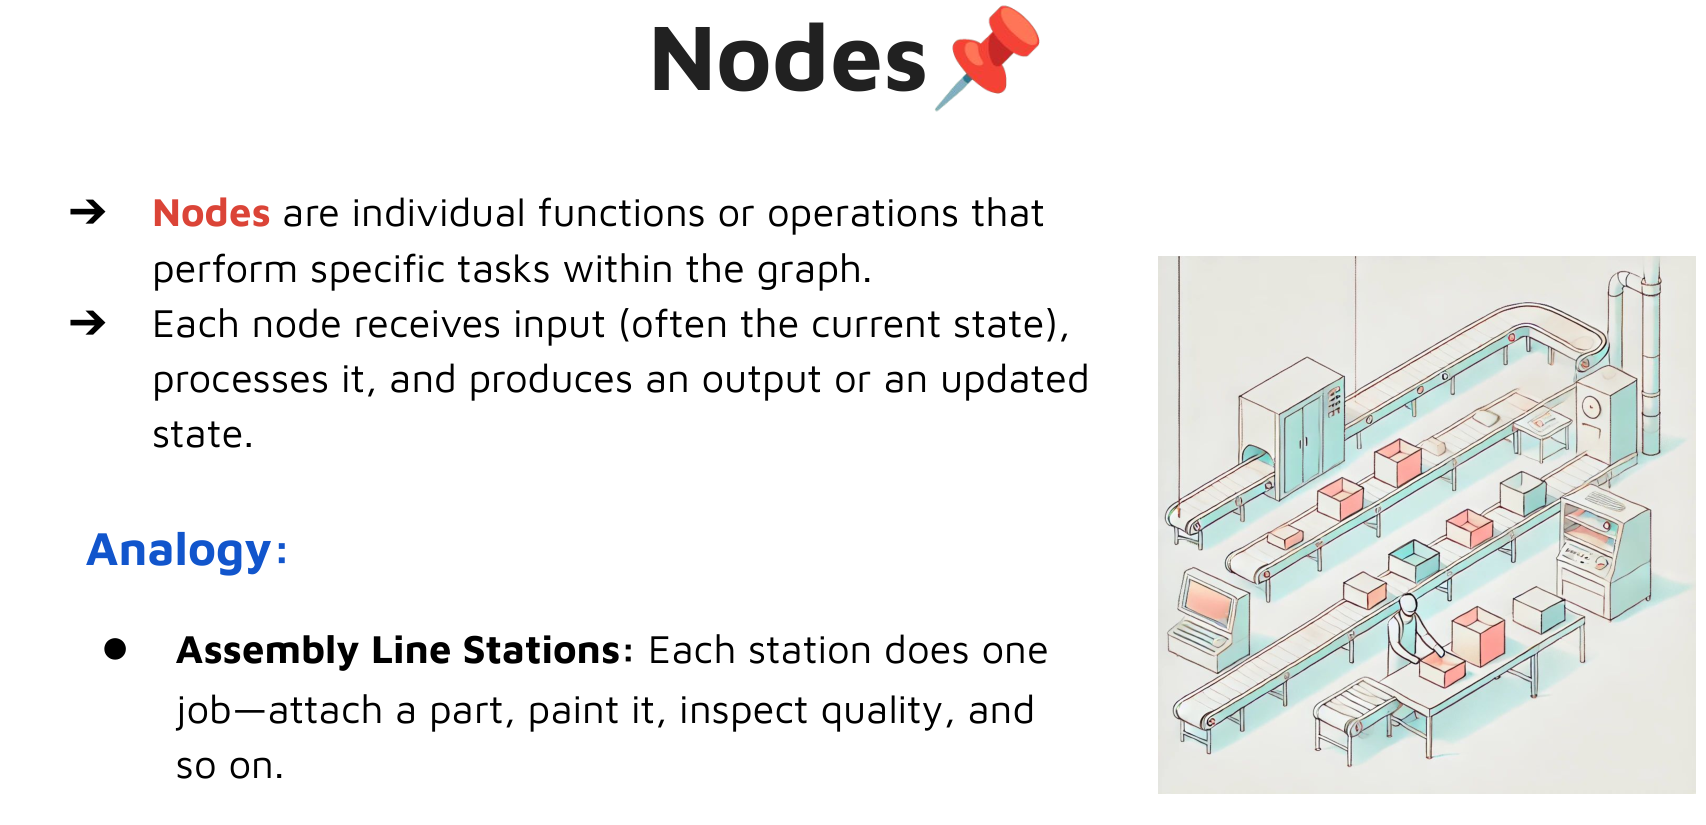

1. **Nodes**:
    
    - Represent discrete steps in your workflow
    - Each node has a single responsibility (data transformation, validation, decision-making)
    - Promotes modular design that reduces complexity
    - Enables isolated testing and maintenance

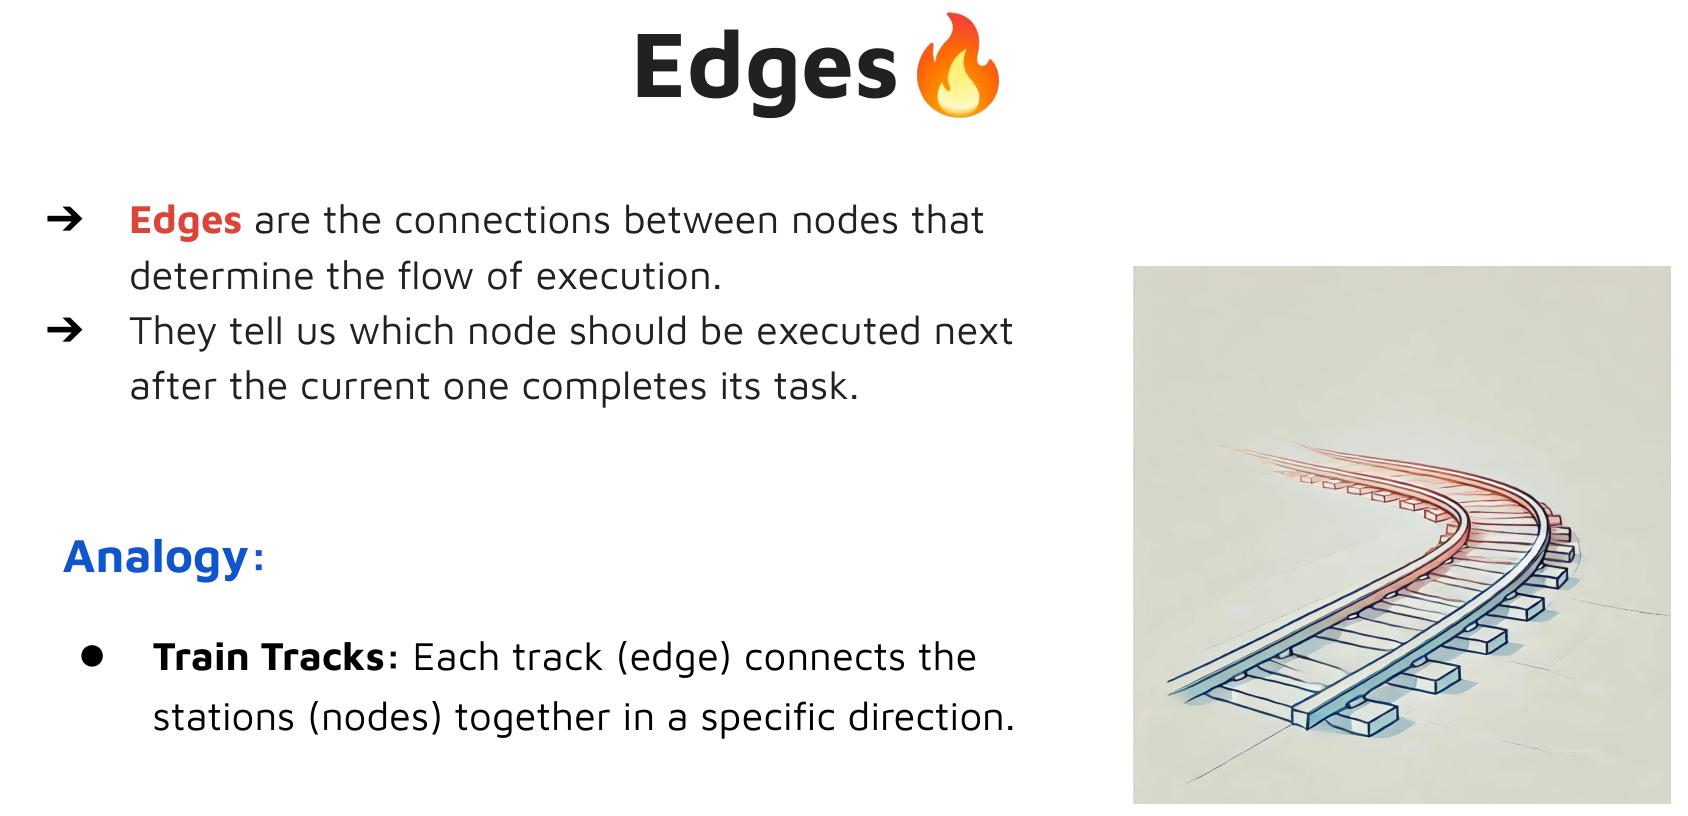

2. **Edges**:
    
    - Define the order in which nodes run
    - Act as directed connections between workflow steps
    - Ensure outputs from one node become inputs to the next
    - Create explicit control over data flow

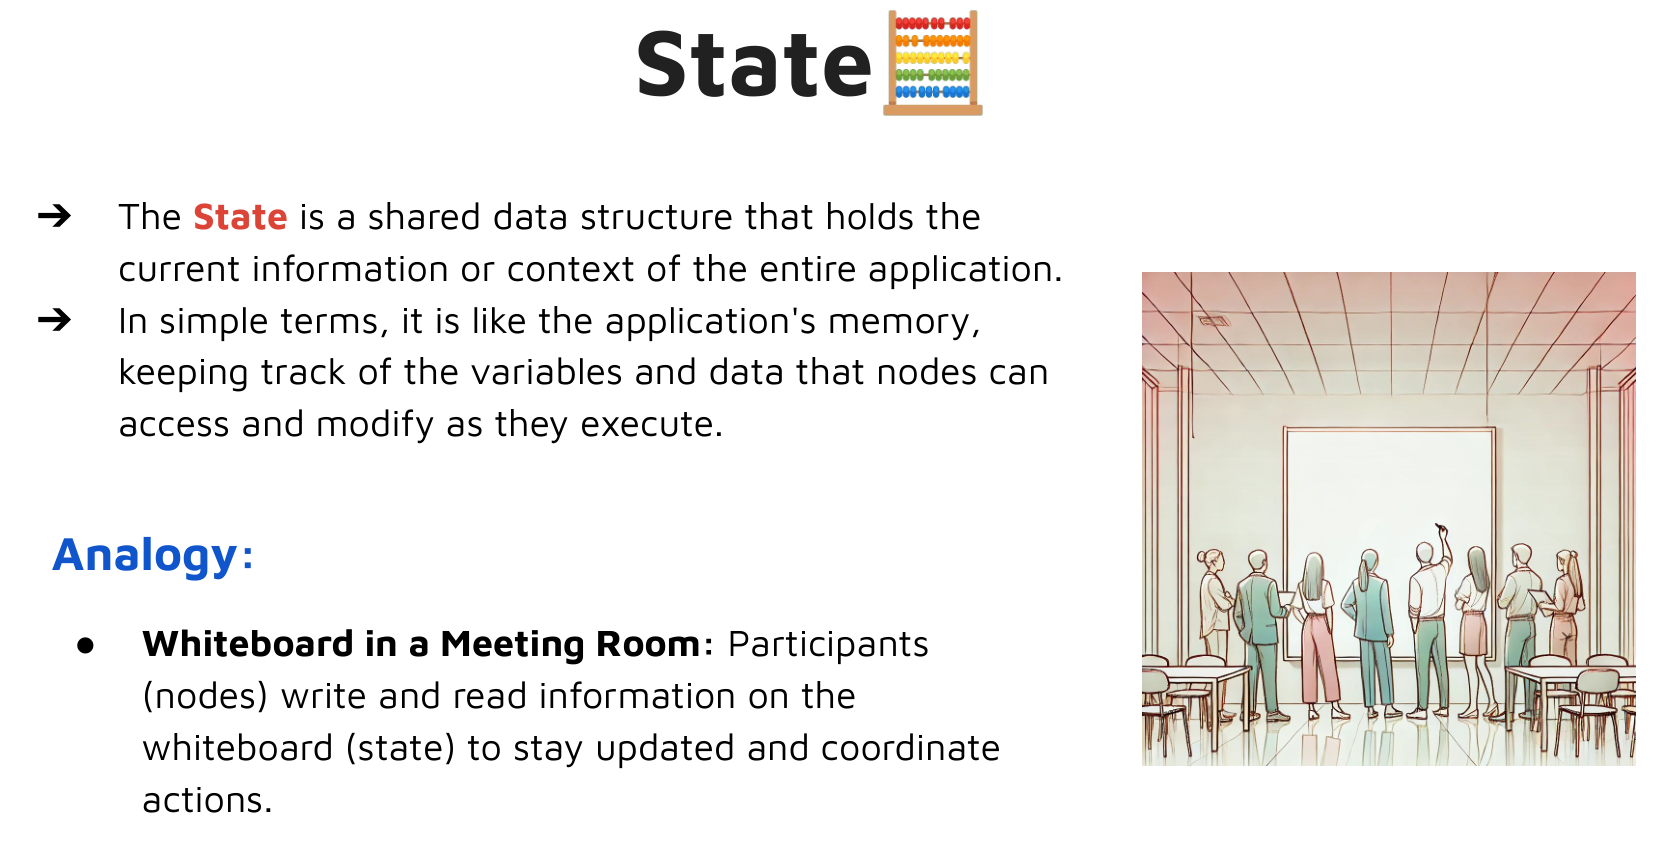

3. **Shared State**:
   
	- The State is a shared data structure and represents the current snapshot of the app.
    - Carries data between nodes throughout the execution
    - Each node reads from, modifies, or augments the state according to its role
    - Avoids tight coupling seen in monolithic guard classes
    - Provides transparency about what data passes to each node

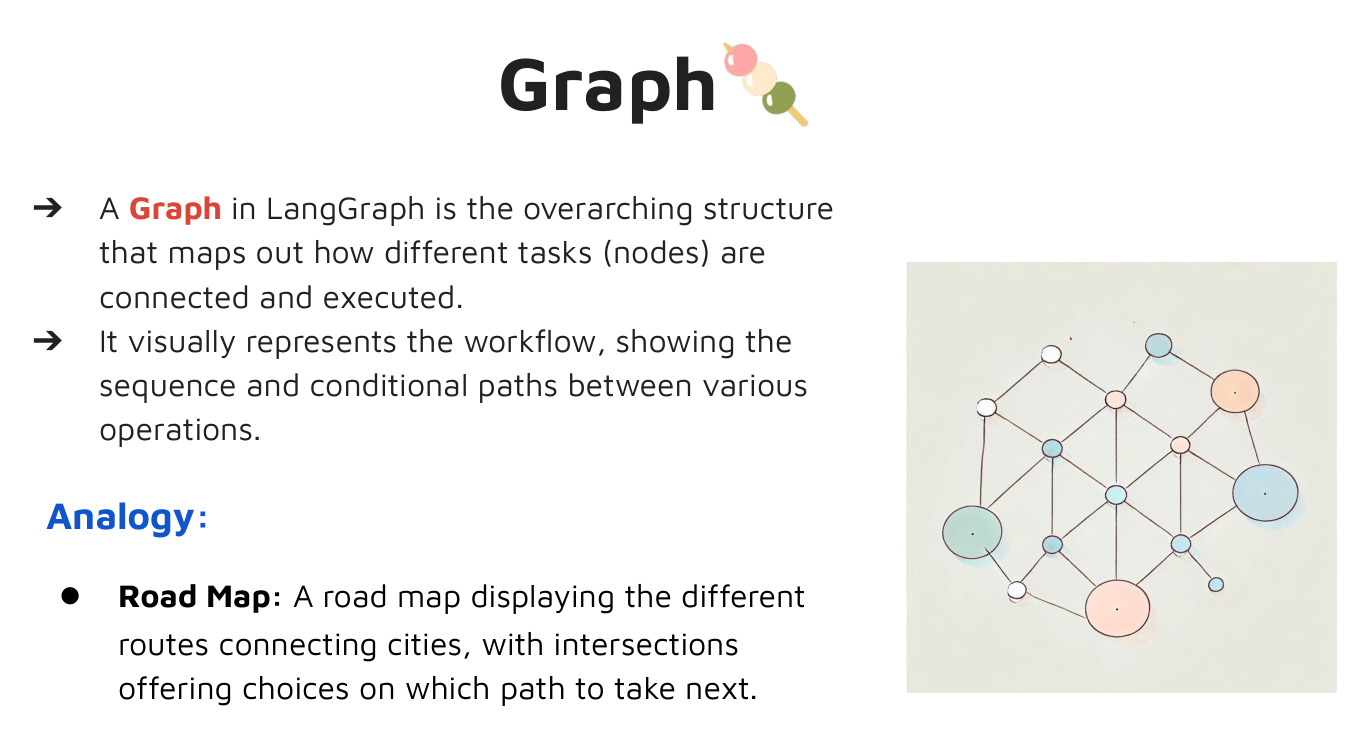

---

LangGraph is created to define cyclical graphs. Graphs consist of the following elements:

- Nodes represent actual actions and can be either LLMs, agents or functions. Also, a special END node marks the end of execution.
- Edges connect nodes and determine the execution flow of your graph. There are basic edges that simply link one node to another and conditional edges that incorporate if-statements and additional logic.


### Graph (Workflow)
The overall structure that combines state, nodes, and edges into a cohesive executable process.

### State
The data structure that carries and tracks information as it moves through the workflow.

### Nodes
The individual steps in each workflow, each performing a specific task or transformation on the state.

### Edges
The connections between nodes defining the order and conditions under which transitions occur.

In [21]:
# !pip install langgraph

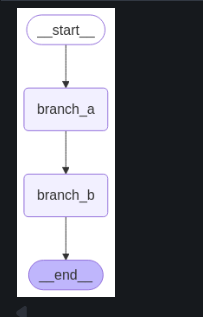

In [24]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class InputState(TypedDict):
    string_value: str
    numeric_value: int

def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)


graph.add_edge(START, "branch_a")
graph.add_edge("branch_a","branch_b" )
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

In [26]:
from IPython.display import Image

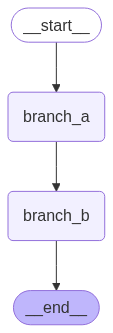

In [27]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [28]:
runnable.invoke({"string_value": "a"})

Current value: {'string_value': 'a'}
Current value: {'string_value': 'a'}


{'string_value': 'a'}

In [32]:
runnable.invoke({"string_value": "a", "numeric_value":9})

Current value: {'string_value': 'a', 'numeric_value': 9}
Current value: {'string_value': 'a', 'numeric_value': 9}


{'string_value': 'a', 'numeric_value': 9}

In [ ]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input

test = {
    "string_value": 'a',
    "numeric_value":1
}

print(modify_state(test))

print(test)



{'string_value': 'aa', 'numeric_value': 2}
{'string_value': 'aa', 'numeric_value': 2}


In [44]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()


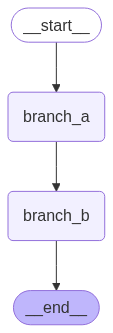

In [45]:
display(Image(runnable.get_graph().draw_mermaid_png()))


In [56]:
try:
    print(runnable.invoke({"string_value": "a", "numeric_value":1}))
except KeyError as e:
    print(e)

{'string_value': 'aaa', 'numeric_value': 3}


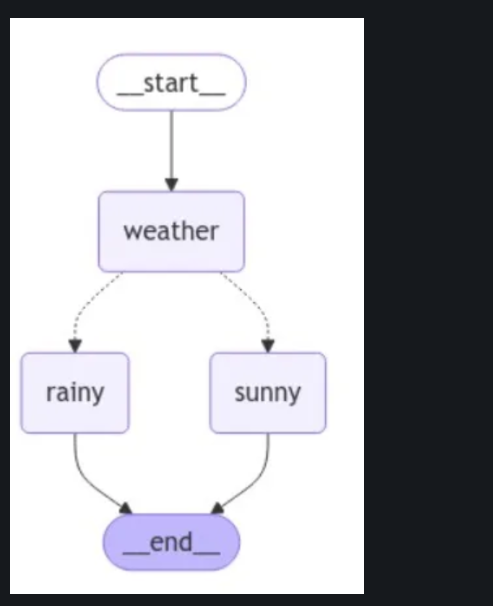

----

## Reducer Functions

In [65]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add


class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]


def modify_state(input: InputState):
    return input

In [66]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [67]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
    }
)

{'no_change_value': 'a',
 'string_value': 'aaaa',
 'numeric_value': 4,
 'list_value': ['a', 'a', 'a', 'a']}

In [68]:
## Alternate State

from typing import TypedDict
from langgraph.graph import END, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


# class InputState(BaseModel):
#       string_value: str
#       numeric_value: int


def modify_state(input: InputState):
    string_value = input["string_value"]
    # string_value = input.string_value
    print(string_value)
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [69]:
runnable.invoke({"string_value": "a", "numeric_value": "a"})

a
a


{'string_value': 'a', 'numeric_value': 'a'}

----

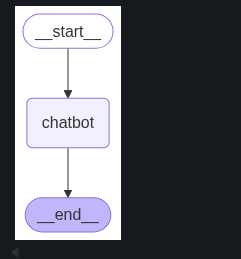

## LangGraph Basic chatbot:
https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/

In [57]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    


graph_builder = StateGraph(State)

In [59]:

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)





In [61]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)




In [62]:
graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

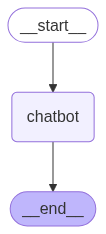

In [63]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [64]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hi there! How can I help you today?
Assistant: Hi Nikhil! It's great to meet you and hear you're diving into new technologies!

It sounds like you might be referring to **LangGraph** or **LangChain** – both are powerful frameworks often used for building applications with Large Language Models.

Which one are you focusing on, or is it something else entirely?

Either way, I'd be happy to help! What specifically are you working on, or what questions do you have about it?
Assistant: In LangGraph, the **"state"** is the central, shared, and mutable data structure that represents the current context and progress of your graph's execution.

Think of it as a **shared blackboard** or a **global dictionary** that all the nodes in your graph can read from and write to.

Here's a breakdown of what a state is and why it's fundamental in LangGraph:

1.  **Centralized Source of Truth:**
    *   At any given point during the graph's execution, the state holds all the relevant information.